In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [8]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
# from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
# from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice
from fee_algorithm.based_on_trade_count_fee import BasedOnTradeCountFee
from fee_algorithm.adaptive_fee_based_on_block_price_move import AdaptiveBasedOnPreviousBlockPriceMoveFee

from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "based_on_trade_count_fee": BasedOnTradeCountFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    # "adaptive_based_on_previous_block_price_move_fee": AdaptiveBasedOnPreviousBlockPriceMoveFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    # "discrete_fee_perfect_oracle": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    # "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    # "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(alpha=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [9]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=HistoricalDataDescription(start_time=datetime.datetime(2024, 3, 1, 12, 0), end_time=datetime.datetime(2024, 3, 31, 12, 0), A_symbol='ETH', B_symbol='SHIB', stable_coin_symbol='USDT', candle_interval='1m'), fee_algorithm=FixedFee(exchange_fee_rate=0.003), informed_user=InformedUser(), uninformed_users=UninformedUsersConfig(uninformed_user=UninformedUser(mu=0.00016, sigma=1e-05), probability_of_trade=0.5, n_users=1), initial_pool_value=25000000, network_fee=5)


In [10]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    experiment_results[experiment_name] = run_experiment(experiment_config)

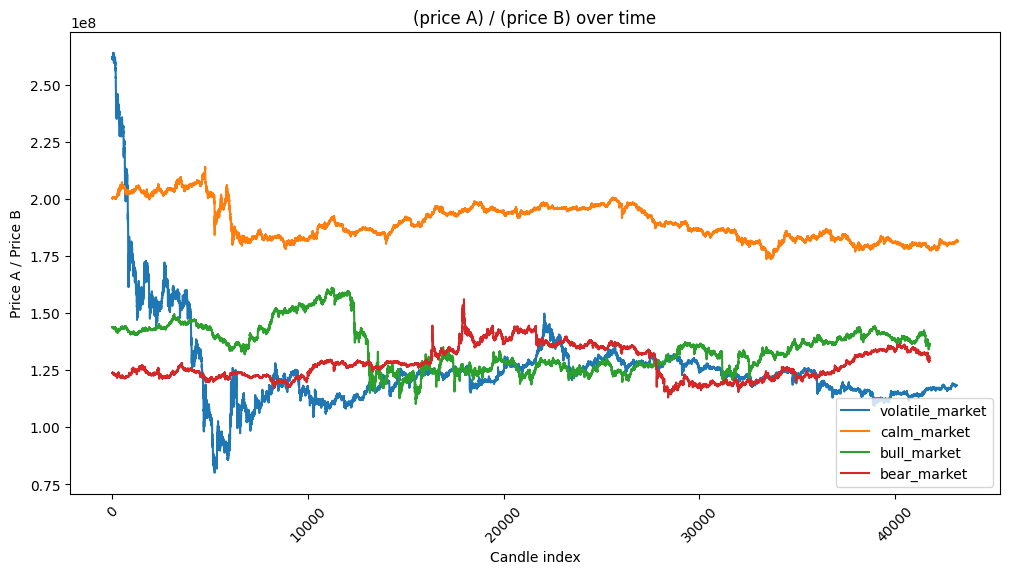

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_A"] / experiment_result.data["price_B"], label=period_alias)
    plt.title("(price A) / (price B) over time")

plt.ylabel("Price A / Price B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

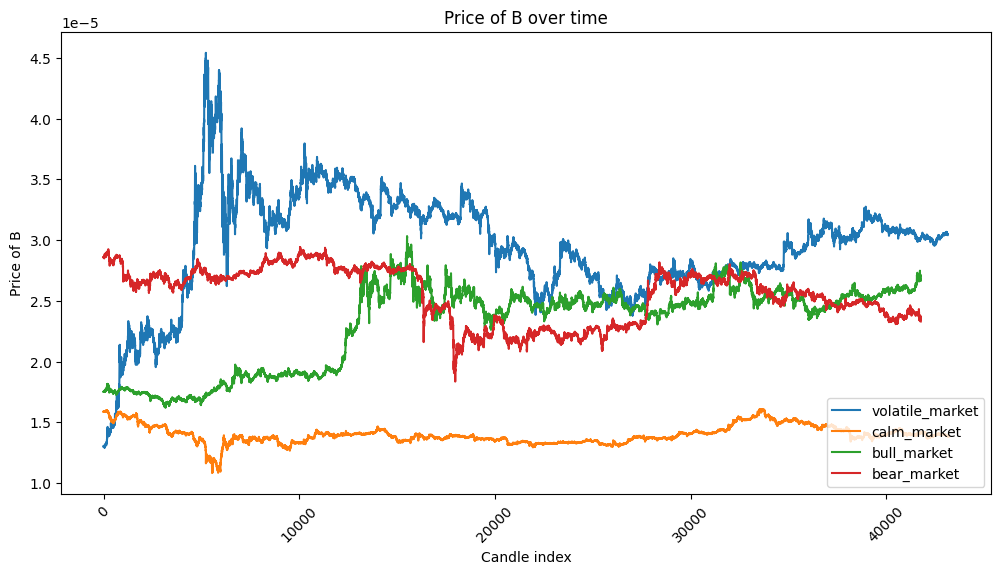

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [13]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [14]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

    return summary

### Results for bull market

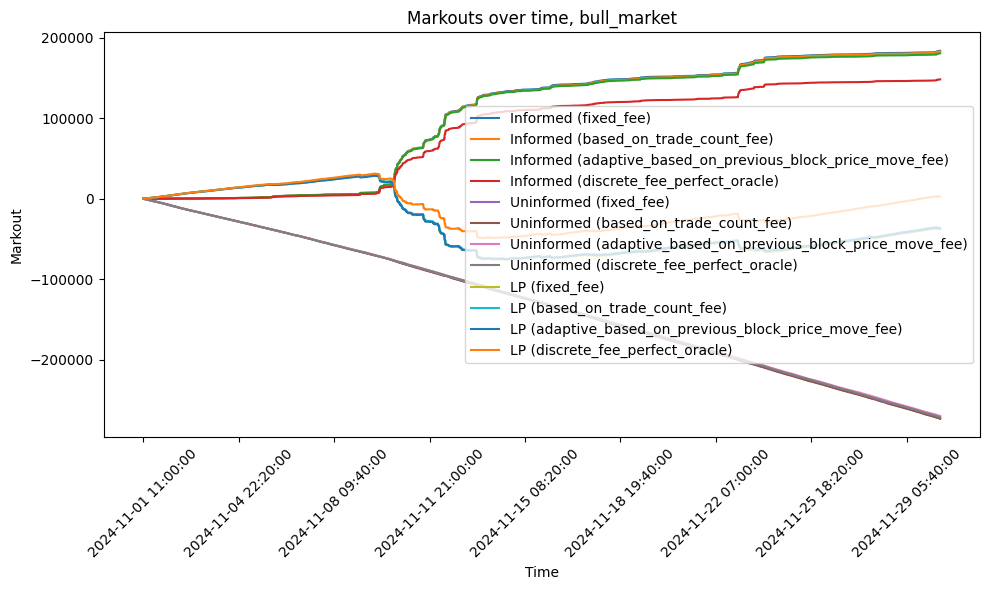

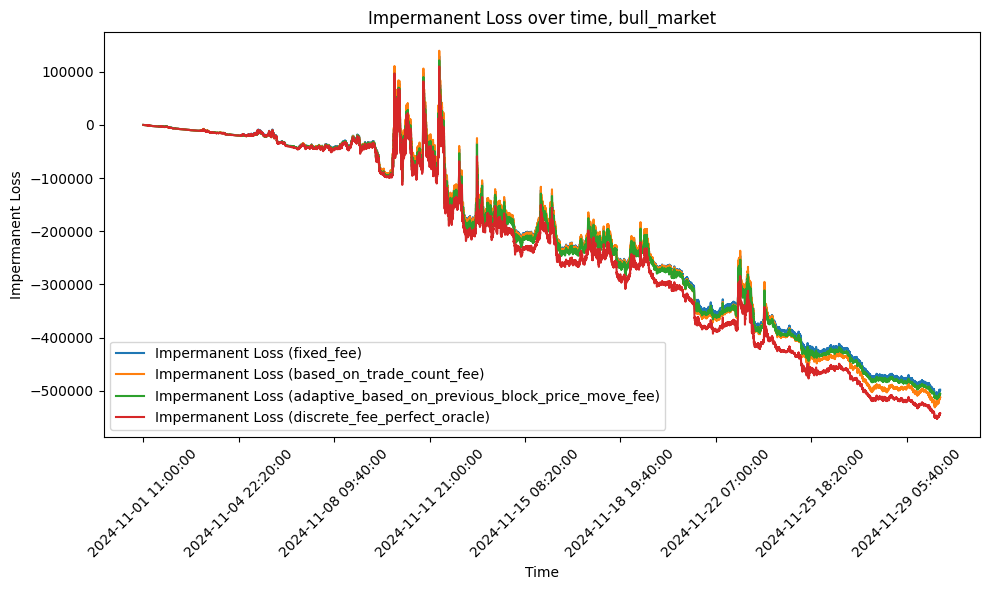

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,183885.20,4459,-272719.97,20864,-37780.23,-497942.00
1,based_on_trade_count_fee,183091.02,4410,-273177.16,20837,-36148.86,-512479.41
2,adaptive_based_on_previous_block_price_move_fee,180638.61,4392,-269787.73,20782,-36720.88,-505209.70
3,discrete_fee_perfect_oracle,148359.50,3243,-271359.24,20813,2719.73,-541722.54


In [9]:
bull_market_summary = plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

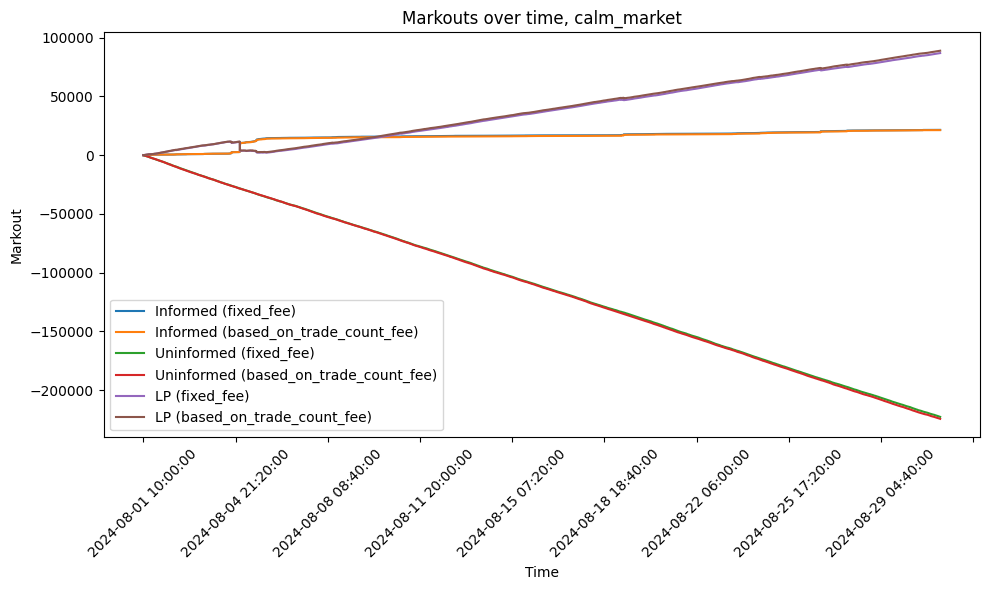

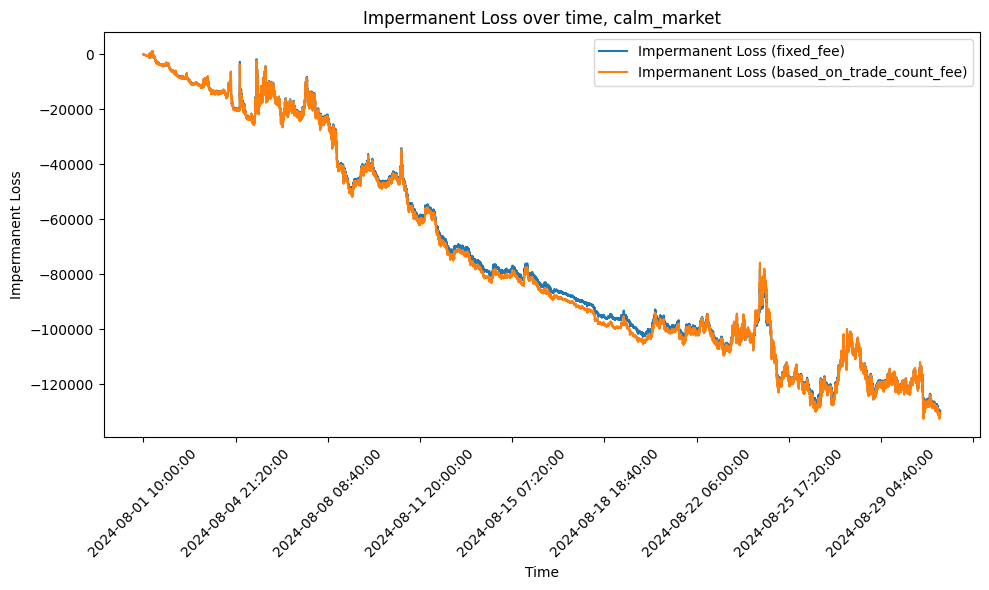

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,21547.33,1388,-222801.41,21478,86924.08,-129736.31
1,based_on_trade_count_fee,21326.49,1386,-224479.16,21460,88922.67,-130708.31


In [15]:
calm_market_summary = plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

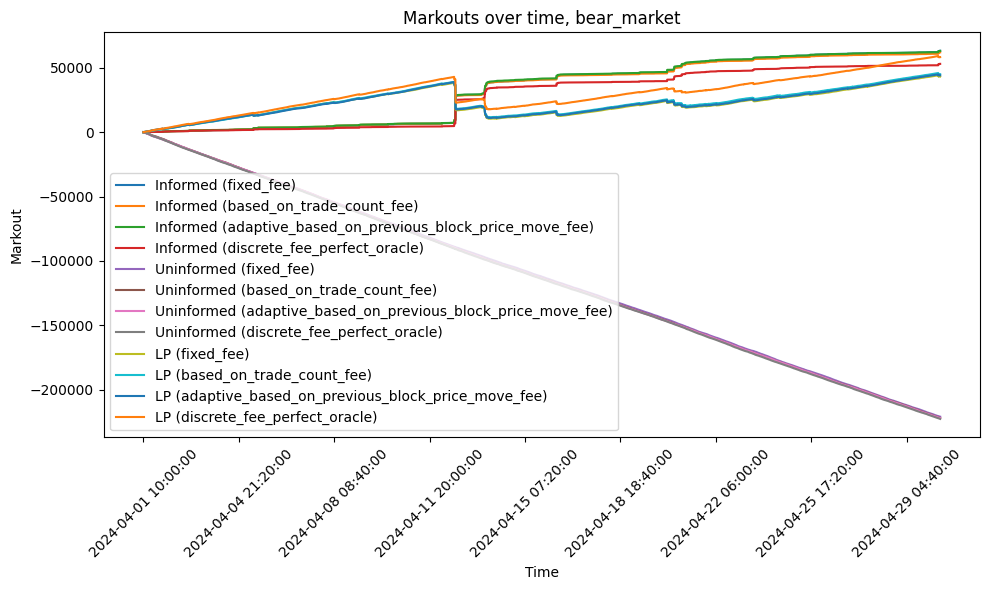

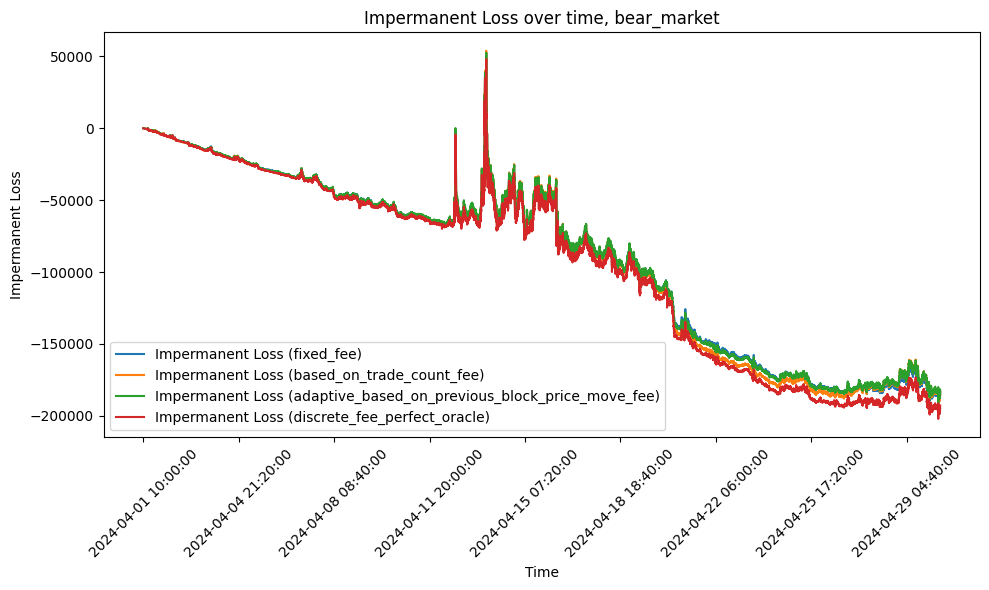

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,63221.84,2199,-221016.89,20718,43210.05,-183518.44
1,based_on_trade_count_fee,61989.66,2195,-222020.00,20811,45000.34,-182912.90
2,adaptive_based_on_previous_block_price_move_fee,63081.51,2208,-222167.81,20784,44126.30,-181757.01
3,discrete_fee_perfect_oracle,53033.05,1538,-222756.76,20756,58253.71,-192817.69


In [11]:
bear_market_summary = plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

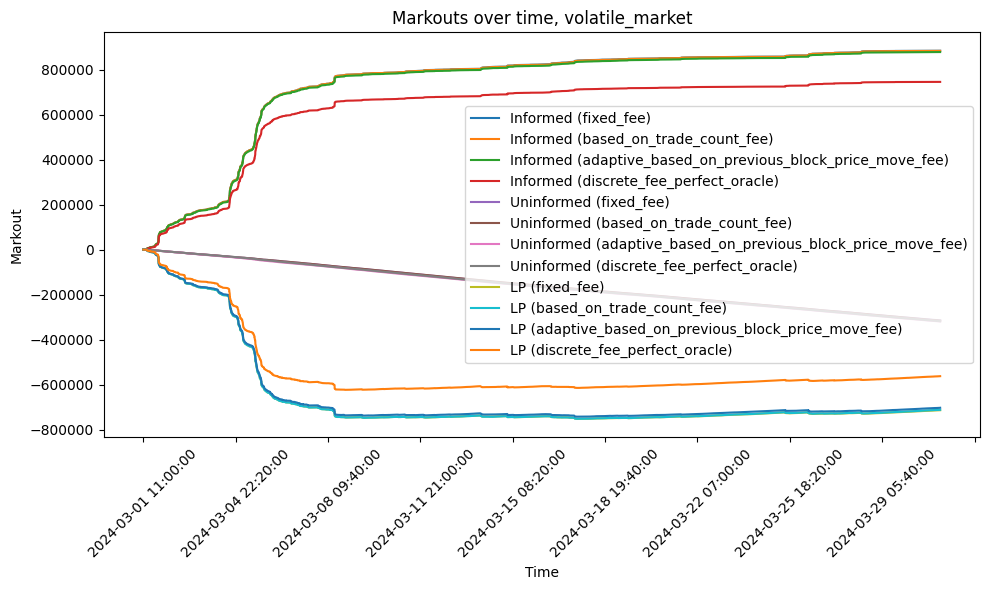

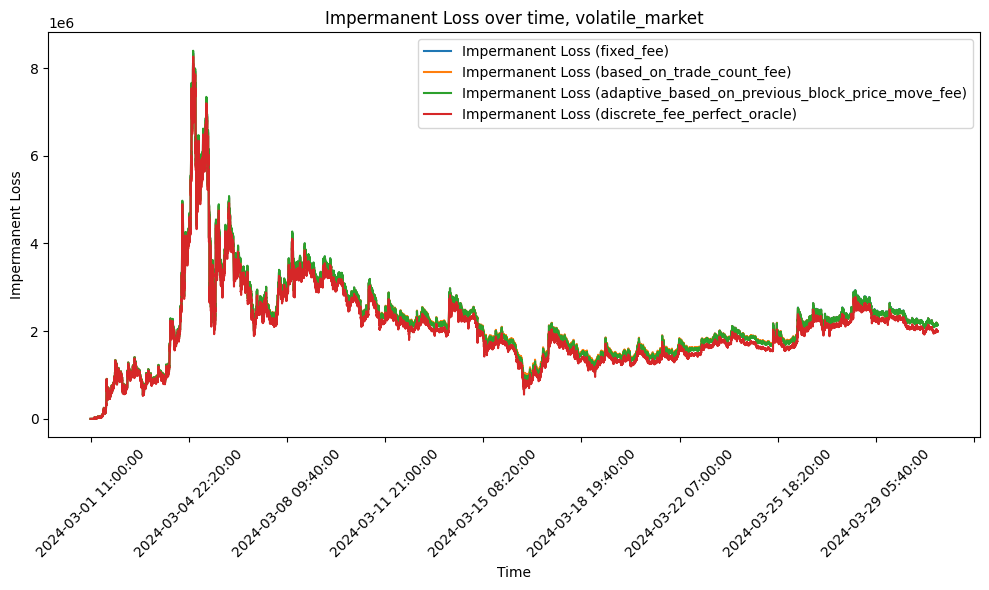

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,883899.75,7421,-314528.43,21415,-713551.32,2146636.20
1,based_on_trade_count_fee,883295.34,7412,-315492.24,21380,-711763.10,2145809.77
2,adaptive_based_on_previous_block_price_move_fee,878087.52,7320,-319057.25,21421,-702735.26,2140245.48
3,discrete_fee_perfect_oracle,745470.74,5563,-318140.83,21426,-562274.91,1995396.68


In [12]:
volatile_market_summary = plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

### All results

In [13]:
import pandas as pd

bull_market_summary["period_alias"] = "bull"
calm_market_summary["period_alias"] = "calm"
bear_market_summary["period_alias"] = "bear"
volatile_market_summary["period_alias"] = "volatile"

combined_df = pd.concat([volatile_market_summary, calm_market_summary, bull_market_summary, bear_market_summary], ignore_index=True)

combined_df = combined_df.set_index(['period_alias'])

display(combined_df)

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
period_alias,,,,,,,
volatile,fixed_fee,883899.75,7421,-314528.43,21415,-713551.32,2146636.20
volatile,based_on_trade_count_fee,883295.34,7412,-315492.24,21380,-711763.10,2145809.77
volatile,adaptive_based_on_previous_block_price_move_fee,878087.52,7320,-319057.25,21421,-702735.26,2140245.48
volatile,discrete_fee_perfect_oracle,745470.74,5563,-318140.83,21426,-562274.91,1995396.68
calm,fixed_fee,21547.33,1388,-222801.41,21478,86924.08,-129736.31
calm,based_on_trade_count_fee,21326.49,1386,-224479.16,21460,88922.67,-130708.31
calm,adaptive_based_on_previous_block_price_move_fee,21556.81,1449,-222935.93,21510,86584.12,-130465.17
calm,discrete_fee_perfect_oracle,17768.01,1016,-223127.23,21453,93014.22,-135422.48
bull,fixed_fee,183885.20,4459,-272719.97,20864,-37780.23,-497942.00


In [14]:
combined_df.to_markdown()

'| period_alias   | experiment_name                                 |   iu_markout |   iu_trade_count |   uu_markout |   uu_trade_count |   lp_markout |   impermanent_loss |\n|:---------------|:------------------------------------------------|-------------:|-----------------:|-------------:|-----------------:|-------------:|-------------------:|\n| volatile       | fixed_fee                                       |     883900   |             7421 |      -314528 |            21415 |   -713551    |        2.14664e+06 |\n| volatile       | based_on_trade_count_fee                        |     883295   |             7412 |      -315492 |            21380 |   -711763    |        2.14581e+06 |\n| volatile       | adaptive_based_on_previous_block_price_move_fee |     878088   |             7320 |      -319057 |            21421 |   -702735    |        2.14025e+06 |\n| volatile       | discrete_fee_perfect_oracle                     |     745471   |             5563 |      -318141 |            

In [15]:
### Just more readable visualization of same df

# Round the DataFrame to 2 decimal places
df = combined_df.reset_index().round(2)  # Ensure the index levels are retained as columns

# Styling function for alternating background colors and bold text
def highlight_periods(row):
    unique_periods = df['period_alias'].unique()  # Access the 'period_alias' column
    colors = [
        'background-color: #f2f2f2;',  # Light gray
        'background-color: #d9eaf7;',  # Pastel blue
        'background-color: #eaf7d9;',  # Pastel green
        'background-color: #fff6cc;',  # Pastel yellow
    ]
    group_index = list(unique_periods).index(row['period_alias'])
    return [colors[group_index % len(colors)]] * len(row)

def make_numbers_bold(val):
    """Make all numeric values bold."""
    if isinstance(val, (int, float, str)):
        return 'font-weight: bold; color: #000;'
    return ''  # No styling for non-numeric values

# Format numbers to 2 decimal places
def format_numbers(val):
    """Ensure all numeric values are formatted to 2 decimal places."""
    if isinstance(val, (int, float)):
        return f'{val:.2f}'
    return val

# Apply alternating background colors, bold styling, and number formatting
styled_df = (
    df.style
    .apply(highlight_periods, axis=1)
    .applymap(make_numbers_bold)
    .format(format_numbers)  # Apply number formatting
)

styled_df

/var/folders/48/7_jn2w696tq1pr_p7zr8krnc0000gq/T/ipykernel_47372/1815749587.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df.style


,period_alias,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,volatile,fixed_fee,883899.75,7421.00,-314528.43,21415.00,-713551.32,2146636.20
1,volatile,based_on_trade_count_fee,883295.34,7412.00,-315492.24,21380.00,-711763.10,2145809.77
2,volatile,adaptive_based_on_previous_block_price_move_fee,878087.52,7320.00,-319057.25,21421.00,-702735.26,2140245.48
3,volatile,discrete_fee_perfect_oracle,745470.74,5563.00,-318140.83,21426.00,-562274.91,1995396.68
4,calm,fixed_fee,21547.33,1388.00,-222801.41,21478.00,86924.08,-129736.31
5,calm,based_on_trade_count_fee,21326.49,1386.00,-224479.16,21460.00,88922.67,-130708.31
6,calm,adaptive_based_on_previous_block_price_move_fee,21556.81,1449.00,-222935.93,21510.00,86584.12,-130465.17
7,calm,discrete_fee_perfect_oracle,17768.01,1016.00,-223127.23,21453.00,93014.22,-135422.48
8,bull,fixed_fee,183885.20,4459.00,-272719.97,20864.00,-37780.23,-497942.00
9,bull,based_on_trade_count_fee,183091.02,4410.00,-273177.16,20837.00,-36148.86,-512479.41


### Fee based on trade count state

In [16]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional
from pool.liquidity_state import PoolLiquidityState

def plot_fee_based_on_trade_count_fee_history(experiment_result: ExperimentResult, fee_algo_name: str, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    a_to_b_fees = []
    b_to_a_fees = []
    
    
    for snapshot in all_snapshots:
        a_to_b_fees.append(snapshot.pool.fee_algorithm.a_to_b_exchange_fee_rate)
        b_to_a_fees.append(snapshot.pool.fee_algorithm.b_to_a_exchange_fee_rate)

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, a_to_b_fees, label="A to B exchange fee rate")
    ax.plot(all_timestamps, b_to_a_fees, label="B to A exchange fee rate")
    ax.set_xlabel("Time")
    ax.set_ylabel("Exchange fee rate")
    ax.legend(loc="upper right")
    plt.title(f"Exchange fee rate over time for {fee_algo_name} algorithm")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

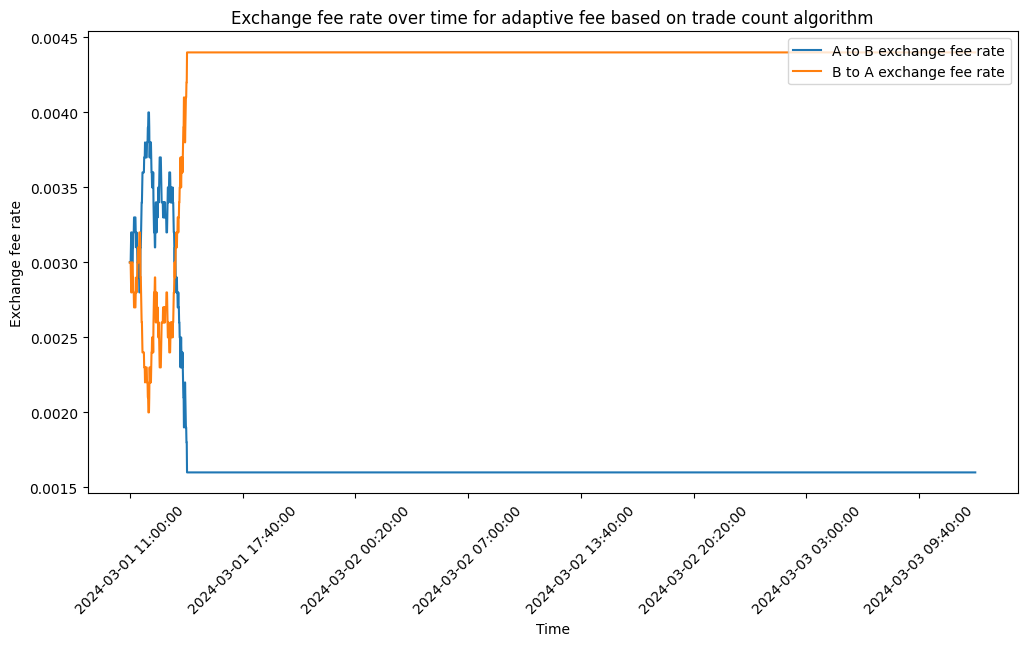

In [17]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results["volatile_market_based_on_trade_count_fee"], 
    "adaptive fee based on trade count",
    3000,
)

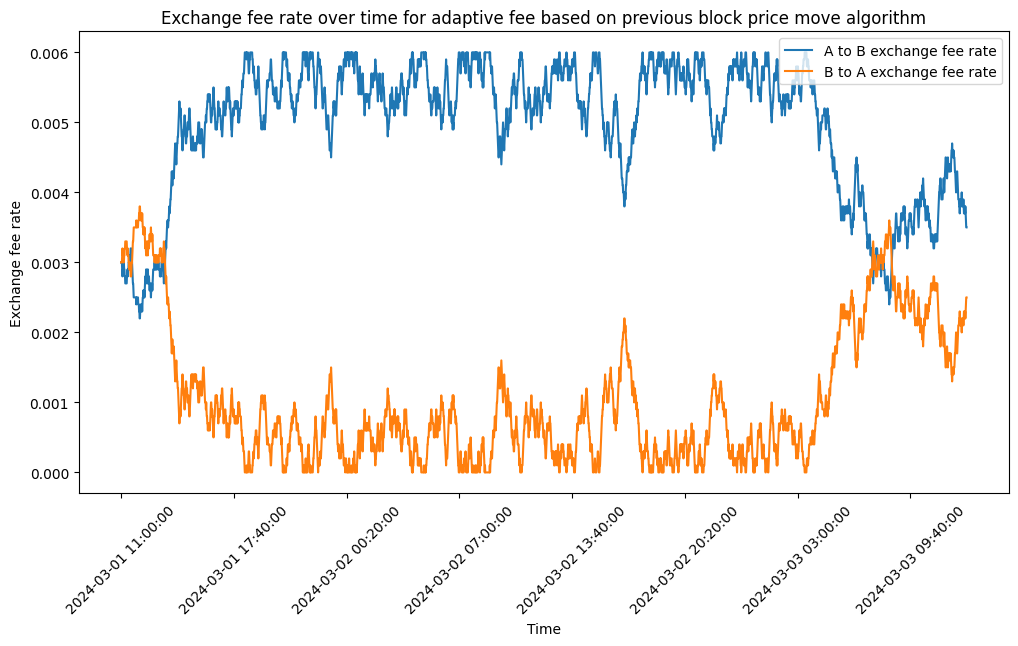

In [18]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results["volatile_market_adaptive_based_on_previous_block_price_move_fee"], 
    "adaptive fee based on previous block price move",
    3000,
)

### Fee based on price ema state

In [19]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional

def plot_fee_algo_price_ema_vs_price(experiment_result: ExperimentResult, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    fee_algo_price_ema = []
    for snapshot in all_snapshots:
        fee_algo_price_ema.append(snapshot.pool.fee_algorithm.a_to_b_price_ema.average())
    
    real_prices = []
    for snapshot in all_snapshots:
        real_prices.append(snapshot.pool.get_a_to_b_exchange_price())
    

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, fee_algo_price_ema, label="EMA of price from fee algorithm")
    ax.plot(all_timestamps, real_prices, label="Real price")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(loc="upper right")
    plt.title("EMA of price from fee algorithm vs real price")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

In [20]:
# plot_fee_algo_price_ema_vs_price(
#     experiment_results["volatile_market_fee_based_on_historical_price"], first_updates=100
# )